This notebook is about identifying stroke and swing for tennis sports.

We are using [Myoarm band](https://www.myo.com/) a wearble device to be worn on your fore arm. This device has accelerometer, gyroscope and magnetometer. Along with that it also has eight EMG(Electic Myo graphy) which measues the activity of the muscle, using this it can identify type of gesture created by hand.

We will be using Accelerometer and Gyroscope data to identify the stroke and swing.
Typically acceleremeter data will help us find type of swing played(Topspin, Slice, Serve, Flat .etc) and gyroscope with help us to find fore hand and back hand stroke.

Currently we are only considereing right handed player for the data collection and modelling, but this model should also work for the left handed player but the output/prediction would be totally opposite(Like forehand will be considered as a backhand).

Importing important libraries

In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from StrokeDetection import StrokeDetection
from data_processing import *
%matplotlib inline

Import data through pandas, 


In [2]:
swing_types = ["backhand_slice", "backhand_topspin", "forehand_slice", "forehand_topspin","no_swing","serve"]
#swing_types = ["forehand_topspin", "backhand_topspin", "backhand_slice", "forehand_slice"]

path = "./data/"
forehand_topspin = path + "train_forehand_set1.csv"
forehand_topspin = load_file(forehand_topspin, "forehand_topspin")
backhand_topspin = path + "train_backhand_topspin_set2.csv"
backhand_topspin = load_file(backhand_topspin, "backhand_topspin")
backhand_slice = path + "train_backhand_slice_set1.csv"
backhand_slice = load_file(backhand_slice, "backhand_slice")
forehand_slice = path + "train_forehand_slice_set2.csv"
forehand_slice = load_file("/Users/shafidayatar/Desktop/train_forehand_slice.csv", "forehand_slice")

noswing = load_file("/Users/shafidayatar/Desktop/train_no_swing.csv", "noswing")

serve = load_file("/Users/shafidayatar/Desktop/training_serve_set1.csv", "serve")


stroke_data = merge_data([forehand_topspin, backhand_topspin, backhand_slice, forehand_slice, serve])
stroke_data.reset_index(drop=True)

#stroke_data = merge_data(forehand_topspin, backhand_topspin)
#stroke_data = merge_data(stroke_data, backhand_slice)
time, gyr, acc, quaternion  = get_lables(stroke_data)
stroke_y = get_y(stroke_data)

Given a stream of data from the Myo Device, 
our first goal is to identify the swing is happening or not.

To accomplish this, we came up with the folling algorithm:

1. Normalize the X,Y,Z of accelerometer ( this gives the total G force acting on the device)
2. Pass this Gforce to a butter filter
    1. Butter filter will reduce very high spikes of gforce and increase the low spikes of gforce.
    2. We are creating a tunnel to accept those values which are in between and leave those that are not useful
3. Now we have the filter data, we create a threshold value of 1G, anything above 1G is a swing.
4. We plot the graph to understand the working for the algowithm


This is helper fucntion which will help to plot different graph on runtime

This is about 3d geometery
# Why are we doing this?
We want to show the actual path of the swing in 3d to the player. Using VR Technologies we can play the swing,  using a dummy player and player can visualize the swing.

Quaretion plays a very important role in 3d geometry and it overcomes the problem of gimbla lock. 
Using gyroscope and accelerometer we can find the orientation of the device with quaternions. Myo API has 


We are identify swing from the data and plotting the first swing detected!

serve


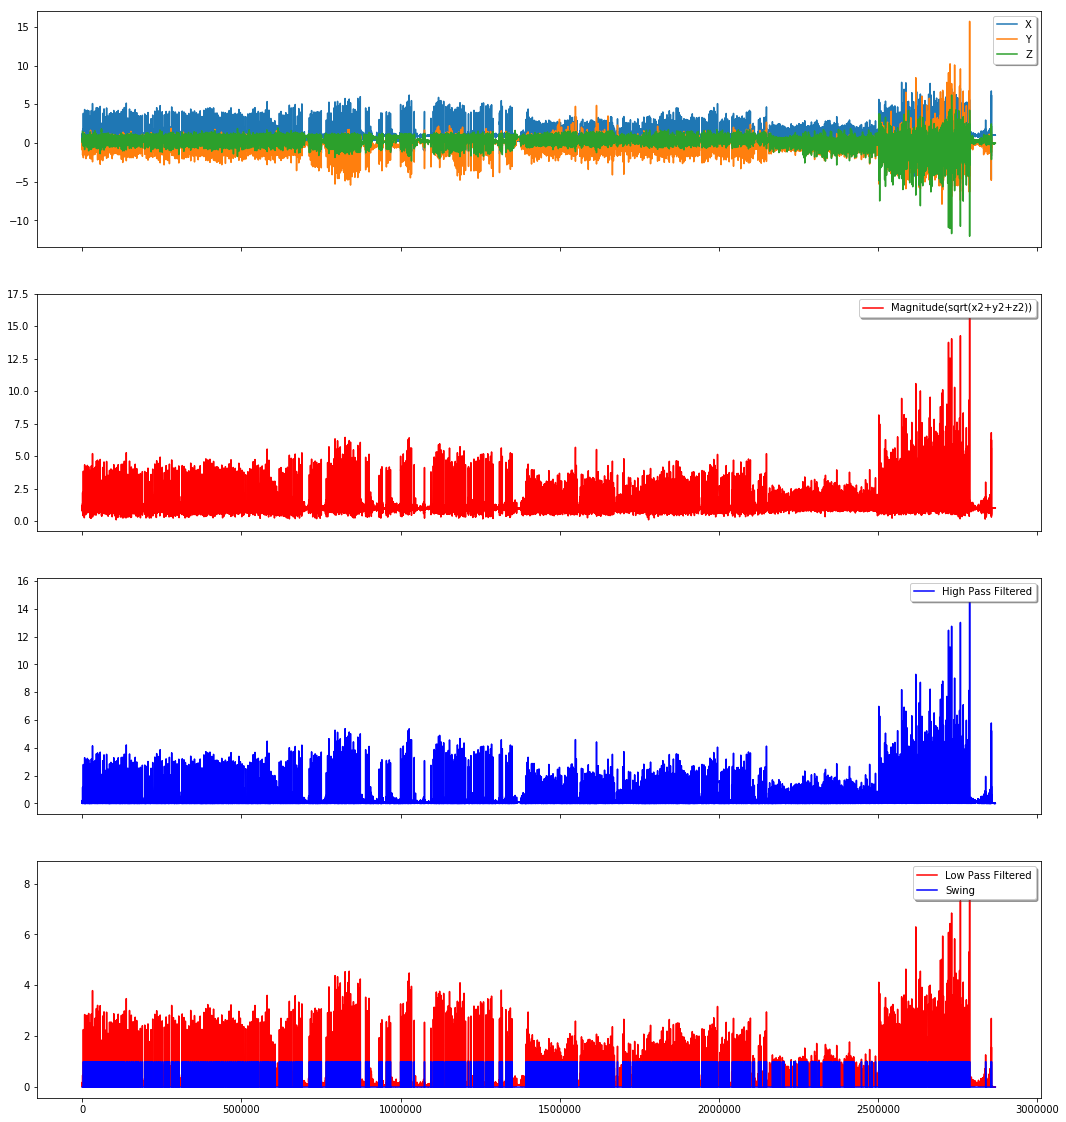

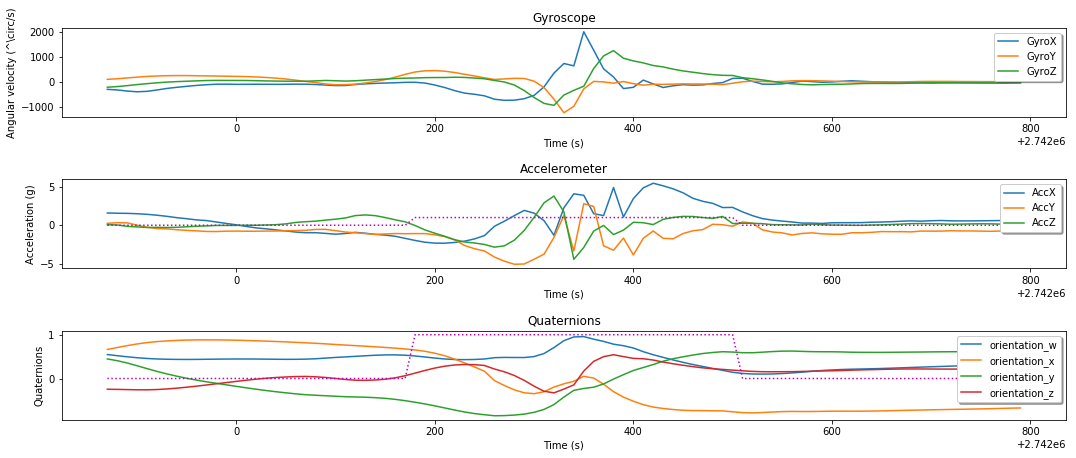

In [3]:
swingPresent = StrokeDetection.identifyStroke(time, acc)
swingMidIndex, swingStartIndex, swingEndIndex, swingPresent = StrokeDetection.strokeIndexes(swingPresent)
startPos = swingStartIndex[600] - 30
endPos = swingEndIndex[600] + 30

print (stroke_y[swingMidIndex[600]])
StrokeDetection.plotSwingData(time, gyr, acc, quaternion, swingPresent, startPos, endPos )

In [4]:
trans_acc, velocity, pos = StrokeDetection.derive_vel_to_pos(acc.copy(), quaternion.as_matrix(), 
                                             swingEndIndex, swingStartIndex, swingPresent)

In [5]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Conv1D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, LeakyReLU
from keras.models import Sequential
from keras.utils import plot_model
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib
from keras.callbacks import ModelCheckpoint

/Users/shafidayatar/anaconda/envs/python2.7-DA/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

def getRandomMultiplier(yvalue):
    if "backhand_slice" == yvalue:
        return 0.95, 1.2
    elif "backhand_topspin" == yvalue:
        return 0.9, 1.1
    elif "forehand_slice" == yvalue:
        return 1.3, 1.7
    elif "forehand_topspin" == yvalue:
        return 0.85, 1.1
    elif "serve" == yvalue:
        return 0.8, 1.05
    else:
        return 0.9, 1.1
    


def generate_train_test_swingIndex(swingMidIndex, stroke_types):
    X_train = X_test = X_val = y_train = y_test = y_val = np.array([])
    swings = stroke_y[swingMidIndex]
    for stroke in stroke_types:
        strokeIndex = swings[swings==stroke].index.values
    
        x1, x2, y1, y2 = train_test_split(strokeIndex, 
                                        swings[stroke_y==stroke], 
                                        test_size=0.3, 
                                        random_state=1, shuffle=True)
        x2, x3, y2, y3 = train_test_split(x2, y2,
                                    test_size=0.5, random_state=1)
        
        X_train = np.concatenate((X_train, x1))
        X_test = np.concatenate((X_test, x2))
        X_val = np.concatenate((X_val, x3))
        y_train = np.concatenate((y_train, y1))
        y_test = np.concatenate((y_test, y2))
        y_val = np.concatenate((y_val, y3))
        
    return X_train, X_test, X_val, y_train, y_test, y_val

def swingDataAugmenation(x, randStart=0.9, randEnd=1.1):
    x_features, y_label = [], []
    
    # for each swing generate 50, 3 matrix by sliding 15 data points before and 15 data points after
    #this will give us 30 swings in total each swing. 
    for index in x: 
        Y_value = stroke_y.iloc[index]
        randStart, randEnd = getRandomMultiplier(Y_value)
        rand = np.random.uniform(randStart, randEnd,(20))
        for i in range(20):
            a = acc.iloc[index - 25 - i : index + 25 - i].as_matrix().T
            a = np.multiply(a, rand[i])
            g = gyr.iloc[index - 25 - i : index + 25 - i].as_matrix().T
            q = quaternion.iloc[index - 25 - i:index + 25 - i].as_matrix().T
            a = np.concatenate((a,g), axis=0)
            a = np.concatenate((a,q), axis=0)
            x_features.append(a)
            y_label.append(Y_value)
            a = acc.iloc[index - 25 + i : index + 25 + i].as_matrix().T
            g = gyr.iloc[index - 25 + i:index + 25 + i].as_matrix().T
            q = quaternion.iloc[index - 25 + i : index + 25 + i].as_matrix().T
            a = np.concatenate((a,g), axis=0)
            a = np.concatenate((a,q), axis=0)
            x_features.append(a)
            y_label.append(Y_value)
            
    return np.array(x_features), np.array(y_label)

def noSwingDataAugmenation(data, Y_value="no_swing", sample_size=4000):
    x_features, y_label = [], []
    startIndex = 5
    endIndex = data.shape[0]-1

    while(startIndex<endIndex and endIndex-startIndex > 50):
        a = acc.iloc[startIndex:startIndex + 50].as_matrix().T
        g = gyr.iloc[startIndex:startIndex + 50].as_matrix().T
        q = quaternion.iloc[startIndex:startIndex + 50].as_matrix().T
        y_label.append(Y_value)
        a = np.concatenate((a,g), axis=0)
        a = np.concatenate((a,q), axis=0)
        x_features.append(a)

        startIndex += 15;
        if(len(x_features) == sample_size):
            break;
    
    X_input, y_output = np.array(x_features), np.array(y_label)
    x1, x2, y1, y2 = train_test_split(X_input, 
                                        y_output, 
                                        test_size=0.3, 
                                        random_state=1, shuffle=True)
    x2, x3, y2, y3 = train_test_split(x2, y2,
                                    test_size=0.5, random_state=1)
    
    return x1, x2, x3, y1, y2, y3


def generate_one_hot_label(y, label_count):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(y)
    swing_targets = np_utils.to_categorical(integer_encoded, len(swing_types))
    return swing_targets
        

    
print ("total swing type count", stroke_y[swingMidIndex].value_counts())  
X_train, X_test, X_val, y_train, y_test, y_val = generate_train_test_swingIndex(
                        swingMidIndex, swing_types)
print ("training swing count ", np.unique(y_train, return_counts=True))
print ("test swing count ", np.unique(y_test, return_counts=True))
print ("val swing count ", np.unique(y_val, return_counts=True))

X_train, y_train = swingDataAugmenation(X_train.astype(int))
X_val, y_val = swingDataAugmenation(X_val.astype(int))
X_test, y_test = swingDataAugmenation(X_test.astype(int))




## adding noswing data to training set:
x1, x2, x3, y1, y2, y3 = noSwingDataAugmenation(noswing)

X_train = np.concatenate((X_train, x1))
X_test = np.concatenate((X_test, x2))
X_val = np.concatenate((X_val, x3))
y_train = np.concatenate((y_train, y1))
y_test = np.concatenate((y_test, y2))
y_val = np.concatenate((y_val, y3))

print ("After agumentation training swing count ", np.unique(y_train, return_counts=True))
print ("After agumentation test swing count ", np.unique(y_test, return_counts=True))
print ("After agumentation val swing count ", np.unique(y_val, return_counts=True))

X_train = np.expand_dims(X_train, 4)
X_val = np.expand_dims(X_val, 4)
X_test = np.expand_dims(X_test, 4)

y_train = generate_one_hot_label(y_train, len(swing_types))
y_test = generate_one_hot_label(y_test, len(swing_types))
y_val = generate_one_hot_label(y_val, len(swing_types))


('total swing type count', backhand_slice      204
forehand_topspin    132
backhand_topspin    112
serve               110
forehand_slice       63
Name: stroke, dtype: int64)
('training swing count ', (array(['backhand_slice', 'backhand_topspin', 'forehand_slice',
       'forehand_topspin', 'serve'], dtype=object), array([142,  78,  44,  92,  77])))
('test swing count ', (array(['backhand_slice', 'backhand_topspin', 'forehand_slice',
       'forehand_topspin', 'serve'], dtype=object), array([31, 17,  9, 20, 16])))
('val swing count ', (array(['backhand_slice', 'backhand_topspin', 'forehand_slice',
       'forehand_topspin', 'serve'], dtype=object), array([31, 17, 10, 20, 17])))
('After agumentation training swing count ', (array(['backhand_slice', 'backhand_topspin', 'forehand_slice',
       'forehand_topspin', 'no_swing', 'serve'], dtype='|S16'), array([5680, 3120, 1760, 3680, 2800, 3080])))
('After agumentation test swing count ', (array(['backhand_slice', 'backhand_topspin', 'foreha

/Users/shafidayatar/anaconda/envs/python2.7-DA/lib/python2.7/site-packages/ipykernel_launcher.py:135: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/Users/shafidayatar/anaconda/envs/python2.7-DA/lib/python2.7/site-packages/ipykernel_launcher.py:136: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/Users/shafidayatar/anaconda/envs/python2.7-DA/lib/python2.7/site-packages/ipykernel_launcher.py:137: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [7]:
model = Sequential()
model.add(Conv2D(16, 3, padding="same", activation='relu', input_shape=(10,50,1)))
#model.add(BatchNormalization())
model.add(Conv2D(32, 3, padding="same",activation='relu', kernel_initializer='truncated_normal'))
#model.add(BatchNormalization())
model.add(Conv2D(64, 3, activation='relu', kernel_initializer='truncated_normal'))
#model.add(BatchNormalization())
model.add(Conv2D(128, 3, activation='relu', kernel_initializer='truncated_normal'))
#model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu', kernel_initializer='truncated_normal'))
model.add(Dense(64, activation='relu', kernel_initializer='truncated_normal'))

model.add(Dense(len(swing_types), activation='softmax', kernel_initializer='truncated_normal'))


model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 10, 50, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 50, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 48, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 46, 128)        73856     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
__________

In [8]:
 #X_train, X_test, y_train, y_test
#X_train = X_train.expand_dims(n=4)
filepath="checkpoints/swing_detection_best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
trained = model.fit(X_train, y_train, epochs=5, batch_size=20, 
                    validation_data=(X_val, y_val), callbacks=[checkpoint],
                    verbose=1)

Train on 20120 samples, validate on 4400 samples
Epoch 1/5
20120/20120 [==============================] - 63s 3ms/step - loss: 0.2839 - acc: 0.9086 - val_loss: 0.1084 - val_acc: 0.9707

Epoch 00001: val_loss improved from inf to 0.10842, saving model to checkpoints/swing_detection_best_weights.hdf5
Epoch 2/5
20120/20120 [==============================] - 62s 3ms/step - loss: 0.0891 - acc: 0.9759 - val_loss: 0.0873 - val_acc: 0.9748

Epoch 00002: val_loss improved from 0.10842 to 0.08726, saving model to checkpoints/swing_detection_best_weights.hdf5
Epoch 3/5
20120/20120 [==============================] - 61s 3ms/step - loss: 0.0659 - acc: 0.9817 - val_loss: 0.1103 - val_acc: 0.9775

Epoch 00003: val_loss did not improve from 0.08726
Epoch 4/5
20120/20120 [==============================] - 61s 3ms/step - loss: 0.0620 - acc: 0.9829 - val_loss: 0.1173 - val_acc: 0.9770

Epoch 00004: val_loss did not improve from 0.08726
Epoch 5/5
20120/20120 [==============================] - 61s 3ms/step

['acc', 'loss', 'val_acc', 'val_loss']


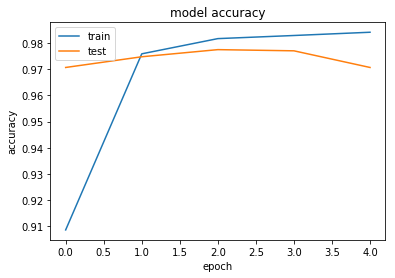

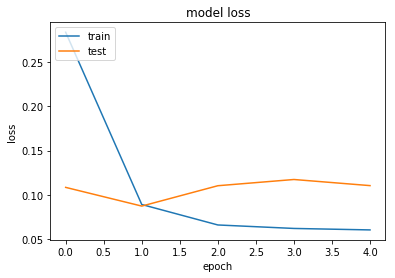

In [9]:
# list all data in history
print(trained.history.keys())
# summarize history for accuracy
plt.plot(trained.history['acc'])
plt.plot(trained.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
#
model.load_weights("checkpoints/swing_detection_best_weights.hdf5")
model_prediction = [np.argmax(model.predict(np.expand_dims(test_vector, 0))) for test_vector in X_test]
test_accuracy = 100*np.sum(model_prediction==np.argmax(y_test,axis=1))/len(model_prediction)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 97.0000%


In [11]:
def export_model_for_mobile(model_name, input_node_names, output_node_name):
    K.set_learning_phase(0)
    tf.train.write_graph(K.get_session().graph_def, 'out', \
        model_name + '_graph.pbtxt')

    tf.train.Saver().save(K.get_session(), 'out/' + model_name + '.chkp')

    print (freeze_graph.freeze_graph('out/' + model_name + '_graph.pbtxt', None, \
        False, 'out/' + model_name + '.chkp', output_node_name, \
        "save/restore_all", "save/Const:0", \
        'out/frozen_' + model_name + '.pb', True, ""))

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open('out/frozen_' + model_name + '.pb', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_names, [output_node_name],
            tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile('out/tensorflow_lite_' + model_name + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())
        

        
export_model_for_mobile("stroke_prediction", ["conv2d_1_input"], "dense_3/Softmax")

INFO:tensorflow:Restoring parameters from out/stroke_prediction.chkp
INFO:tensorflow:Froze 14 variables.
Converted 14 variables to const ops.
None


In [12]:
"""
Convert model.ckpt to model.pb
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow.python.framework import graph_util

# create a session
sess = tf.Session()

# import best model
saver = tf.train.import_meta_graph('model.ckpt.meta') # graph
saver.restore(sess, 'model.ckpt') # variables

# get graph definition
gd = sess.graph.as_graph_def()

# fix batch norm nodes
for node in gd.node:
  if node.op == 'RefSwitch':
    node.op = 'Switch'
    for index in xrange(len(node.input)):
      if 'moving_' in node.input[index]:
        node.input[index] = node.input[index] + '/read'
  elif node.op == 'AssignSub':
    node.op = 'Sub'
    if 'use_locking' in node.attr: del node.attr['use_locking']

# generate protobuf
converted_graph_def = graph_util.convert_variables_to_constants(sess, gd, ["logits_set"])
tf.train.write_graph(converted_graph_def, '/path/to/save/', 'model.pb', as_text=False)

IOError: File model.ckpt.meta does not exist.

In [ ]:
!ls temp_data

In [ ]:
file_name = "temp_data/" + "test_dhruvi_set3_4_fht_2_bht_1_bhs.csv"
test_file = load_file(file_name, "forehand_slice")


#stroke_data = merge_data(forehand_topspin, backhand_topspin)
#stroke_data = merge_data(stroke_data, backhand_slice)
test_time, test_gyr, test_acc, test_quaternion  = get_lables(test_file)
test_time = test_time.cumsum()

testSwing = StrokeDetection.identifyStroke(test_time, test_acc)
t_sm, t_ss, t_se, t_sp = StrokeDetection.strokeIndexes(testSwing)

def getTestSwing(x):
    test_features = []
    for index in x: 
        Y_value = stroke_y.iloc[index]
        a = test_acc.iloc[index-25:index+25].as_matrix().T
        g = test_gyr.iloc[index-25:index+25].as_matrix().T
        q = test_quaternion.iloc[index-25:index+25].as_matrix().T
        a = np.concatenate((a,g), axis=0)
        a = np.concatenate((a,q), axis=0)
        test_features.append(a)
    return np.array(test_features)

swing_test = getTestSwing(t_sm)

print swing_test.shape
swing_test = np.expand_dims(swing_test,4)
print swing_test.shape  


In [ ]:
model_prediction = np.array([np.argmax(model.predict(np.expand_dims(test_vector, 0))) for test_vector in swing_test])

for swing_idx in model_prediction:
    print swing_types[swing_idx]